In [10]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [17]:
# Constants
MAX_LEN = 128  # Should match what you used during training
MODEL_PATH = './bert_sentiment_model'  # Path to your saved model
TEST_SAMPLE_SIZE = 7500  # Number of samples to use for evaluation

In [12]:
# 1. Load IMDB Dataset
def load_imdb_sample(n_samples=TEST_SAMPLE_SIZE):
    data = pd.read_csv('../../data/raw/IMDB Dataset.csv')
    # Assuming your CSV has 'review' and 'sentiment' columns
    data['label'] = data['sentiment'].map({'negative': 0, 'positive': 1})
    df = pd.DataFrame({
        'text': data['review'],
        'label': data['label']
    })
    return df.sample(n_samples, random_state=42)

In [13]:
# 2. Load Model Function
def load_sentiment_model(model_path):
    """Load the trained model and tokenizer"""
    tokenizer = BertTokenizer.from_pretrained(model_path)
    model = BertForSequenceClassification.from_pretrained(model_path)
    model.to(device)
    return tokenizer, model

In [14]:
# 3. Prediction Function with Confidence
def predict_sentiment(text, tokenizer, model):
    """Predict sentiment with confidence score"""
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=MAX_LEN, padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        confidence, prediction = torch.max(probabilities, dim=1)
    
    sentiment = "positive" if prediction.item() == 1 else "negative"
    return sentiment, confidence.item()

In [15]:
# 4. Comprehensive Evaluation Function
def evaluate_model(model, tokenizer, test_texts, test_labels, batch_size=32):
    """
    Evaluate model and print metrics including:
    - F1 score, accuracy, precision, recall
    - Confusion matrix
    - Classification report
    """
    # Tokenize test data
    encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True, max_length=MAX_LEN)
    input_ids = torch.tensor(encodings['input_ids'])
    attention_mask = torch.tensor(encodings['attention_mask'])
    labels = torch.tensor(test_labels.tolist())
    
    # Create dataset and dataloader
    dataset = TensorDataset(input_ids, attention_mask, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size)
    
    # Get predictions
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    
    # Print metrics
    print("\n" + "="*50)
    print(f"Model Evaluation Metrics (on {len(all_labels)} samples)")
    print("="*50)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=['Negative', 'Positive']))
    
    return {
        'accuracy': accuracy,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'confusion_matrix': cm
    }

Loading model...

Loading IMDB dataset (7500 samples)...

Evaluating model on IMDB dataset...

Model Evaluation Metrics (on 7500 samples)
Accuracy: 0.8935
F1 Score: 0.8957
Precision: 0.8868
Recall: 0.9048


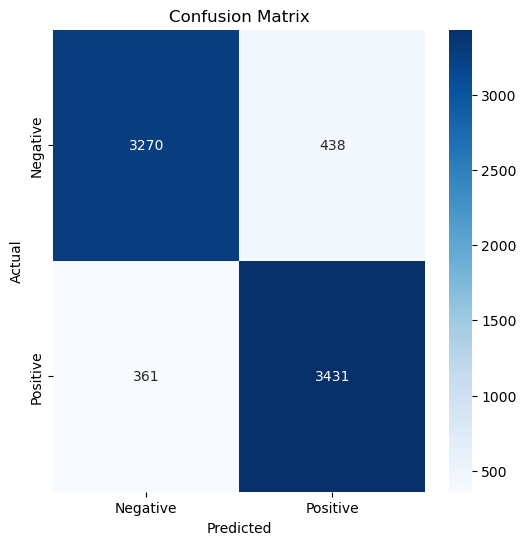


Classification Report:
              precision    recall  f1-score   support

    Negative       0.90      0.88      0.89      3708
    Positive       0.89      0.90      0.90      3792

    accuracy                           0.89      7500
   macro avg       0.89      0.89      0.89      7500
weighted avg       0.89      0.89      0.89      7500


Example Predictions from IMDB dataset:
Text: In New York, in a morning close to Christmas, an upper class father an...
Sentiment: negative (Confidence: 1.00)
--------------------------------------------------------------------------------
Text: Guns blasting, buildings exploding, cars crashing, and that's just the...
Sentiment: positive (Confidence: 0.99)
--------------------------------------------------------------------------------
Text: My wife and I watched this movie because we plan to visit Sicily and S...
Sentiment: negative (Confidence: 1.00)
--------------------------------------------------------------------------------

Evaluati

In [18]:
# 5. Main Execution
if __name__ == "__main__":
    # Load the model
    print("Loading model...")
    tokenizer, model = load_sentiment_model(MODEL_PATH)
    
    # Load IMDB dataset
    print(f"\nLoading IMDB dataset ({TEST_SAMPLE_SIZE} samples)...")
    imdb_df = load_imdb_sample()
    
    # Split into text and labels
    test_texts = imdb_df['text']
    test_labels = imdb_df['label']
    
    # Run evaluation
    print("\nEvaluating model on IMDB dataset...")
    metrics = evaluate_model(model, tokenizer, test_texts, test_labels)
    
    # Example predictions
    print("\nExample Predictions from IMDB dataset:")
    sample_texts = imdb_df.sample(3, random_state=42)['text'].tolist()
    for text in sample_texts:
        sentiment, confidence = predict_sentiment(text, tokenizer, model)
        print(f"Text: {text[:70]}...")
        print(f"Sentiment: {sentiment} (Confidence: {confidence:.2f})")
        print("-" * 80)
    
    print("\nEvaluation complete!")